In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate as integrate
from matplotlib import gridspec
import scipy.signal
import healpy as hp
from numba import jit
import pandas as pd
import readgadget as rg
import multiprocessing
import math
import statistics as st
import plotting_library as PL

from pylab import *
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
import scipy.fftpack
import density_field_library as DFL
import Pk_library as PKL

## Cubical (Over)Density Field Peak-Curves Function Testing

In [2]:
def PeakCurves(DensityFields=[], Nreals=10, MaxThreshold=16, Nthresh=101, Type=0, Plot=1, LogScale=1, CosmoLabels=['null']):
    '''
    Gives the peak curves for the given cosmologies' square (over)density fields.
    
    Parameters
    ----------
    DensityFields: float array of shape ''(nCosmo, NofRealizations, XdfDim, YdfDim)''
        4D Array of the 2D (over)density fields of the various cosmologies to be compared. The array should of shape (nCosmo, NofRealizations, XdfDim, YdfDim) 
        where 'nCosmo' is the number of cosmologies to be compared, 'NofRealizations' is the number of realizations of each input cosmology 
        (NofRealizations >= Nreals), and 'XdfDim' and 'YdfDim' are the dimensions of the 2D density fields in pixels.
        Example: np.array(DensityFields).shape = (3, 10, 512, 512) - 3 cosmologies containing 10 realisations each of (512x512) pixel 2D density fields.
    Nreals: int
        Number of realisations of the density fields to be used for the peak curves' statistics. Naturally, cannot be larger than the inherent number 
        of realisations of the 2D density fields contained within the (.npy) data files input, i.e. in the above example, Nreals <=10. Any non-int values 
        are type-cast to int.
    MaxThreshold: float
        Maximum overdensity threshold for which the peak values are to be plotted.
    Nthresh: int
        Number of overdensity threshold (X-axis) values to be computed in the closed interval [-1,MaxThreshold]. Any non-int values are type-cast to int.
    Type: int: 0 or 1, optional
        Type of peak curve to be plotted - 0 for raw peak curve plot; 1 for peak curves normalized by the first input cosmology's peak curve.
    Plot: int: 0 or 1, optional
        1 to plot the output and return results, 0 to skip plotting and only return results. Any values other than 1 will skip plotting.
    LogScale: int: 0 or 1, optional
        1 to plot the peak curves on log Y-axis, 0 to not use log Y-axis. Any values other than 1 will not output the log scale.
    CosmoLabels: str array of shape ''(nCosmo)''
        List of the names/labels to be assigned to the respective input cosmologies. Must have length equal to the number of cosmologies input ('nCosmo').
        Example: ['CDM', 'SIDM', 'FDM']
            
    Returns
    -------
    thresh, tmean, tstddev: 3 numpy arrays containing the threshold values, mean peak values and std. dev. of the peak values
        For (Type = 0): Peak curve plot of the various input comologies' density fields.
        For (Type = 1): Peak curve plot of the various input comologies' density fields normalized by the first input cosmology's density field.
        In both cases, the threshold values array (X-axis, 1D) 'thresh', the peaks array (Y-axis, 2D) 'tmean' containing the number of peaks corresponding to 
        the thresholds array for each input cosmology and their corresponding standard deviations (error, 2D) 'tstddev' are also returned.

    Raises
    ------
    ValueError
        If 'Type' is not 0 or 1.
    ValueError
        If 'Nreals' is lesser than 1.
    ValueError
        If 'MaxThreshold' is lesser than or equal to (-1).
    ValueError
        If the plot needs to be output and the number of labels ('CosmoLabels') is not equal to the number of input cosmologies.
    '''
    if((Type!=0) and (Type!=1)):
        print("ERROR: Incorrect output type requested. Please use either 0 or 1 for variable 'Type'.")
    elif(Nreals<=0):
        print("ERROR: Invalid number of realizations entered. Please enter a positive integer value.")
    elif(MaxThreshold<=-1):
        print("ERROR: Please enter a maximum overdensity threshold value >(-1).")
    elif((Plot==1) and (len(CosmoLabels)!=len(DensityFields))):
        print("ERROR: Please enter the labels for each input cosmology.")
    else:
        Nreals = int(Nreals)
        Nthresh = int(Nthresh)
        b = np.stack(DensityFields)
        peaksarr = double([[[0]*Nreals]*Nthresh]*b.shape[0])
        tmean = double([[0]*Nthresh]*b.shape[0])
        tstddev = double([[0]*Nthresh]*b.shape[0])
        thresh = double([0]*Nthresh)
        peaks = 0
        index = 0
        for t in linspace(-1,MaxThreshold,Nthresh):
            thresh[index]=t
            index+=1
        index=0
        for cosmo in range(0,b.shape[0],1):
            for z in range(0,Nreals,1):
                bz=b[cosmo,z]
                for t in linspace(-1,MaxThreshold,Nthresh):
                    for i in range(0,len(bz),1):
                        for j in range(0,len(bz[i]),1):
                            if((i==0) and (j==0)):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i,j+1]) and (bz[i,j]>=bz[i+1,j]) and (bz[i,j]>=bz[i+1,j+1])) and (bz[i,j]>=bz[len(bz)-1,len(bz)-1]) and (bz[i,j]>=bz[0,len(bz)-1]) and (bz[i,j]>=bz[len(bz)-1,0]) and (bz[i,j]>=bz[len(bz)-1,1]) and (bz[i,j]>=bz[1,len(bz)-1]):
                                    peaks+=1
                            elif((i==0) and (j==(len(bz[i])-1))):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i,j-1]) and (bz[i,j]>=bz[i+1,j-1]) and (bz[i,j]>=bz[i+1,j])) and (bz[i,j]>=bz[len(bz)-1,len(bz)-1]) and (bz[i,j]>=bz[0,0]) and (bz[i,j]>=bz[len(bz)-1,0]) and (bz[i,j]>=bz[1,0]) and (bz[i,j]>=bz[len(bz)-1,len(bz)-2]):
                                    peaks+=1
                            elif((i==(len(bz)-1)) and (j==0)):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i-1,j+1]) and (bz[i,j]>=bz[i,j+1])) and (bz[i,j]>=bz[len(bz)-1,len(bz)-1]) and (bz[i,j]>=bz[0,len(bz)-1]) and (bz[i,j]>=bz[0,0]) and (bz[i,j]>=bz[0,1]) and (bz[i,j]>=bz[len(bz)-2,len(bz)-1]):
                                    peaks+=1
                            elif((i==(len(bz)-1)) and (j==(len(bz[i])-1))):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j-1]) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i,j-1])) and (bz[i,j]>=bz[0,0]) and (bz[i,j]>=bz[0,len(bz)-1]) and (bz[i,j]>=bz[len(bz)-1,0]) and (bz[i,j]>=bz[len(bz)-2,0]) and (bz[i,j]>=bz[0,len(bz)-2]):
                                    peaks+=1
                            elif(i==0):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i,j-1]) and (bz[i,j]>=bz[i,j+1]) and (bz[i,j]>=bz[i+1,j-1]) and (bz[i,j]>=bz[i+1,j]) and (bz[i,j]>=bz[i+1,j+1])) and (bz[i,j]>=bz[len(bz)-1,j-1]) and (bz[i,j]>=bz[len(bz)-1,j]) and (bz[i,j]>=bz[len(bz)-1,j+1]):
                                    peaks+=1
                            elif(i==(len(bz)-1)):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j-1]) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i-1,j+1]) and (bz[i,j]>=bz[i,j-1]) and (bz[i,j]>=bz[i,j+1])) and (bz[i,j]>=bz[0,j-1]) and (bz[i,j]>=bz[0,j]) and (bz[i,j]>=bz[0,j+1]):
                                    peaks+=1
                            elif(j==0):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i-1,j+1]) and (bz[i,j]>=bz[i,j+1]) and (bz[i,j]>=bz[i+1,j]) and (bz[i,j]>=bz[i+1,j+1])) and (bz[i,j]>=bz[i-1,len(bz)-1]) and (bz[i,j]>=bz[i,len(bz)-1]) and (bz[i,j]>=bz[i+1,len(bz)-1]):
                                    peaks+=1
                            elif(j==(len(bz[i])-1)):
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j-1]) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i,j-1]) and (bz[i,j]>=bz[i+1,j-1]) and (bz[i,j]>=bz[i+1,j])) and (bz[i,j]>=bz[i-1,0]) and (bz[i,j]>=bz[i,0]) and (bz[i,j]>=bz[i+1,0]):
                                    peaks+=1
                            else:
                                if((bz[i,j]>=t) and (bz[i,j]>=bz[i-1,j-1]) and (bz[i,j]>=bz[i-1,j]) and (bz[i,j]>=bz[i-1,j+1]) and (bz[i,j]>=bz[i,j-1]) and (bz[i,j]>=bz[i,j+1]) and (bz[i,j]>=bz[i+1,j-1]) and (bz[i,j]>=bz[i+1,j]) and (bz[i,j]>=bz[i+1,j+1])):
                                    peaks+=1                         
                    peaksarr[cosmo,index,z]=double(peaks)
                    peaks=0
                    index+=1
                print('%d%% Done.'%(((double(cosmo)*double(Nreals))+double(z)+1.0)/(0.01*double(Nreals)*b.shape[0])))
                index=0
        if(Type==0):
            for cosmo in range(0,b.shape[0],1):
                for t in range(0,Nthresh,1):
                    tmean[cosmo,t]=np.mean(peaksarr[cosmo,t])
                    tstddev[cosmo,t]=np.std(peaksarr[cosmo,t])
                if(Plot==1):
                    plt.plot(thresh,tmean[cosmo],label=CosmoLabels[cosmo])       
                    plt.fill_between(thresh, tmean[cosmo]-tstddev[cosmo], tmean[cosmo]+tstddev[cosmo], alpha=0.2)
                    plt.title('Peak Curves of Various Cosmologies')
        elif(Type==1):
            for cosmo in range(0,b.shape[0],1):
                for t in range(0,Nthresh,1):
                    tmean[cosmo,t]=np.mean(peaksarr[cosmo,t])/np.mean(peaksarr[0,t])
                    tstddev[cosmo,t]=np.std(peaksarr[cosmo,t])/np.mean(peaksarr[0,t])
                if(Plot==1):
                    plt.plot(thresh,tmean[cosmo],label=CosmoLabels[cosmo])       
                    plt.fill_between(thresh, tmean[cosmo]-tstddev[cosmo], tmean[cosmo]+tstddev[cosmo], alpha=0.2)
                    plt.title('Peak Curves of Various Cosmologies Normalized by ' + CosmoLabels[0])
        if(Plot==1):
            plt.xlabel('Overdensity Threshold')
            plt.ylabel('Number of Peaks')
            if(LogScale==1):
                plt.yscale('log')
            plt.legend(bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0)
            plt.show()
        return thresh, tmean, tstddev

6% Done.
13% Done.
20% Done.
26% Done.
33% Done.
40% Done.
46% Done.
53% Done.
60% Done.
66% Done.
73% Done.
80% Done.
86% Done.
93% Done.
100% Done.


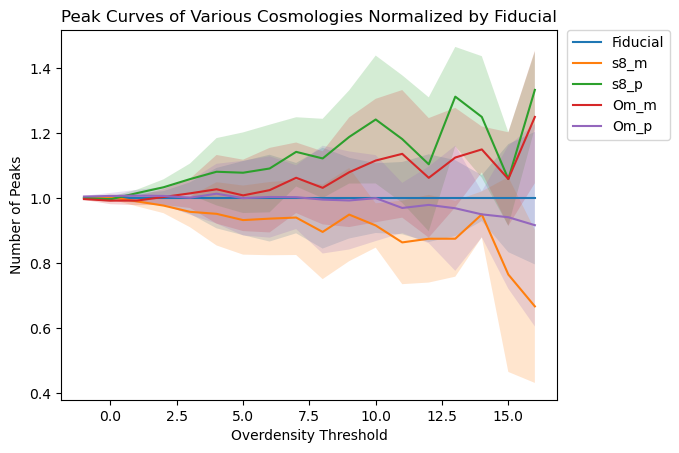

In [8]:
labels = ['Fiducial','s8_m','s8_p','Om_m','Om_p']
df = []
b = []
for i in range(0,10,1):
    b.append(np.load('../Datasets/PeakStatistics/fZA1_zm100.npy')[int(i)])
df.append(b)
b = []
for i in range(0,10,1):
    b.append(np.load('../Datasets/PeakStatistics/s8m1_zm100.npy')[int(i)])
df.append(b)
b = []
for i in range(0,10,1):
    b.append(np.load('../Datasets/PeakStatistics/s8p1_zm100.npy')[int(i)])
df.append(b)
b = []
for i in range(0,10,1):
    b.append(np.load('../Datasets/PeakStatistics/Omm1_zm100.npy')[int(i)])
df.append(b)
b = []
for i in range(0,10,1):
    b.append(np.load('../Datasets/PeakStatistics/Omp1_zm100.npy')[int(i)])
df.append(b)
# print(np.stack(df).shape[0])

thresh, tmean, tstddev = PeakCurves(DensityFields=df, Nreals=3, MaxThreshold=16, Nthresh=18, 
                                    Plot=1, Type=1, LogScale=0, CosmoLabels=labels)

## Skymap (Healpix) Projection (Over)Density Field Peak-Curves Function Testing

[Run cells below in order]

In [9]:
# Peak Finder Function
def spherical_peaks(denslice,MaxThreshold,Nthresh):
    nside = int(np.sqrt(len(denslice)/12))
    nops = 0
    peaks = []
    thresh = []
    neigh = np.copy(hp.pixelfunc.get_all_neighbours(nside,range(len(denslice))))
    for t in linspace(-1,MaxThreshold,Nthresh):
        peax = np.copy(denslice[np.where((denslice[:]>=t)*(denslice[:]>=denslice[neigh[0,:]])*(denslice[:]>=denslice[neigh[1,:]])*(denslice[:]>=denslice[neigh[2,:]])*(denslice[:]>=denslice[neigh[3,:]])*(denslice[:]>=denslice[neigh[4,:]])*(denslice[:]>=denslice[neigh[5,:]])*(denslice[:]>=denslice[neigh[6,:]])*(denslice[:]>=denslice[neigh[7,:]]))])
        nops = len(peax)
        peaks.append(nops)
        thresh.append(t)
    return thresh,peaks

In [10]:
def PeakCurves_Healpix(DensityFields=[], Nreals=10, MaxThreshold=16, Nthresh=101, Type=0, Plot=1, LogScale=1, CosmoLabels=['null']):
    '''
    Gives the peak curves for the given cosmologies' square (over)density fields.
    
    Parameters
    ----------
    DensityFields: float array of shape ''(nCosmo, NofRealizations, nPixels)''
        3D Array of the healpix (over)density fields of the various cosmologies to be compared. The array should of shape (nCosmo, NofRealizations, nPixels) 
        where 'nCosmo' is the number of cosmologies to be compared, 'NofRealizations' is the number of realizations of each input cosmology 
        (NofRealizations >= Nreals), and 'nPixels' is the number of pixels in the healpix projected (over)density field such that [nPixels = 12*res*res], 
        where 'res' is the resolution of the healpix map.
        Example: np.array(DensityFields).shape = (3, 10, 512, 512) - 3 cosmologies containing 10 realisations each of (512x512) pixel 2D density fields.
    Nreals: int
        Number of realisations of the density fields to be used for the peak curves' statistics. Naturally, cannot be larger than the inherent number 
        of realisations of the 2D density fields contained within the (.npy) data files input, i.e. in the above example, Nreals <=10. Any non-int values 
        are type-cast to int.
    MaxThreshold: float
        Maximum overdensity threshold for which the peak values are to be plotted.
    Nthresh: int
        Number of overdensity threshold (X-axis) values to be computed in the closed interval [-1,MaxThreshold]. Any non-int values are type-cast to int.
    Type: int: 0 or 1, optional
        Type of peak curve to be plotted - 0 for raw peak curve plot; 1 for peak curves normalized by the first input cosmology's peak curve.
    Plot: int: 0 or 1, optional
        1 to plot the output and return results, 0 to skip plotting and only return results. Any values other than 1 will skip plotting.
    LogScale: int: 0 or 1, optional
        1 to plot the peak curves on log Y-axis, 0 to not use log Y-axis. Any values other than 1 will not output the log scale.
    CosmoLabels: str array of shape ''(nCosmo)''
        List of the names/labels to be assigned to the respective input cosmologies. Must have length equal to the number of cosmologies input ('nCosmo').
        Example: ['CDM', 'SIDM', 'FDM']
    
    Returns
    -------
    thresh, tmean, tstddev: 3 numpy arrays containing the threshold values, mean peak values and std. dev. of the peak values
        For (Type = 0): Peak curve plot of the various input comologies' density fields.
        For (Type = 1): Peak curve plot of the various input comologies' density fields normalized by the first input cosmology's density field.
        In both cases, the threshold values array (X-axis, 1D) 'thresh', the peaks array (Y-axis, 2D) 'tmean' containing the number of peaks corresponding
        to the thresholds array for each input cosmology and their corresponding standard deviations (error, 2D) 'tstddev' are also returned.

    Raises
    ------
    ValueError
        If 'Type' is not 0 or 1.
    ValueError
        If 'Nreals' is lesser than 1.
    ValueError
        If 'MaxThreshold' is lesser than or equal to (-1).
    ValueError
        If the plot needs to be output and the number of labels ('CosmoLabels') is not equal to the number of input cosmologies.
    '''
    if((Type!=0) and (Type!=1)):
        print("ERROR: Incorrect output type requested. Please use either 0 or 1 for variable 'Type'.")
    elif(Nreals<=0):
        print("ERROR: Invalid number of realizations entered. Please enter a positive integer value.")
    elif(MaxThreshold<=-1):
        print("ERROR: Please enter a maximum overdensity threshold value >(-1).")
    elif((Plot==1) and (len(CosmoLabels)!=len(DensityFields))):
        print("ERROR: Please enter the labels for each input cosmology.")
    else:
        Nreals = int(Nreals)
        Nthresh = int(Nthresh)
        b = np.stack(DensityFields)
        peaksarr = double([[[0]*Nthresh]*Nreals]*b.shape[0])
        tmean = double([[0]*Nthresh]*b.shape[0])
        tstddev = double([[0]*Nthresh]*b.shape[0])
        thresh = double([0]*Nthresh)
        index = 0
        for cosmo in range(0,b.shape[0],1):
            for z in range(0,Nreals,1):
                index += 1
                thresh, peaksarr[cosmo,z] = spherical_peaks(b[cosmo,z],MaxThreshold,Nthresh)
                if(index == b.shape[0]):
                    print('%d%% Done.'%(((double(cosmo)*double(Nreals))+double(z)+1.0)/(0.01*double(Nreals)*b.shape[0])))
                    index = 0
        if(Type == 0):
            for cosmo in range(0,b.shape[0],1):
                tmean[cosmo] = np.mean(peaksarr[cosmo],axis=0)
                tstddev[cosmo] = np.std(peaksarr[cosmo],axis=0)
                if(Plot==1):
                    plt.plot(thresh,tmean[cosmo],label=CosmoLabels[cosmo])       
                    plt.fill_between(thresh, tmean[cosmo]-tstddev[cosmo], tmean[cosmo]+tstddev[cosmo], alpha=0.2)
                    plt.title('Peak Curves of Various Cosmologies')
        elif(Type == 1):
            for cosmo in range(0,b.shape[0],1):
                tmean[cosmo] = np.mean(peaksarr[cosmo],axis=0)/np.mean(peaksarr[0],axis=0)
                tstddev[cosmo] = np.std(peaksarr[cosmo],axis=0)/np.mean(peaksarr[0],axis=0)
                if(Plot==1):
                    plt.plot(thresh,tmean[cosmo],label=CosmoLabels[cosmo])       
                    plt.fill_between(thresh, tmean[cosmo]-tstddev[cosmo], tmean[cosmo]+tstddev[cosmo], alpha=0.2)
                    plt.title('Peak Curves of Various Cosmologies Normalized by ' + CosmoLabels[0])
        if(Plot==1):
            plt.xlabel('Overdensity Threshold')
            plt.ylabel('Number of Peaks')
            if(LogScale == 1):
                plt.yscale('log')
            plt.legend(bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0)
            plt.show()
        return thresh, tmean, tstddev

20% Done.
40% Done.
60% Done.
80% Done.
100% Done.


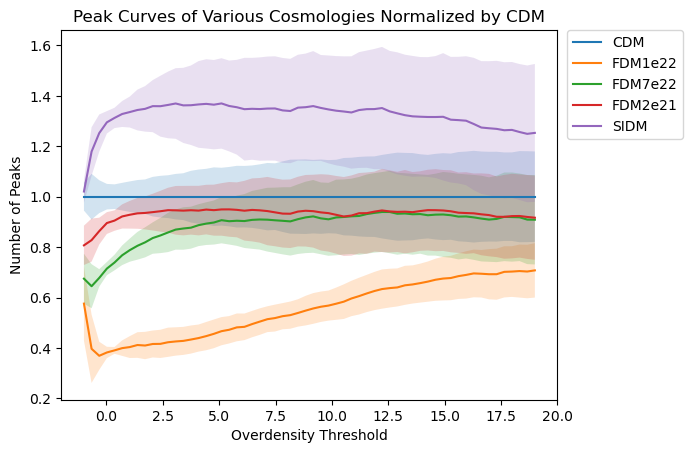

In [11]:
labels = ['CDM','FDM1e22','FDM7e22','FDM2e21','SIDM']
df = []
b = []
for i in range(1,11,1):
    b.append(np.load('../Datasets/PeakStatistics/CDM40_SphericalDensitySlices.npy')[int(i)])
df.append(b)
b = []
for i in range(1,11,1):
    b.append(np.load('../Datasets/PeakStatistics/FDM1e22_SphericalDensitySlices.npy')[int(i)])
df.append(b)
b = []
for i in range(1,11,1):
    b.append(np.load('../Datasets/PeakStatistics/FDM7e22_SphericalDensitySlices.npy')[int(i)])
df.append(b)
b = []
for i in range(1,11,1):
    b.append(np.load('../Datasets/PeakStatistics/FDM2e21_SphericalDensitySlices.npy')[int(i)])
df.append(b)
b = []
for i in range(1,11,1):
    b.append(np.load('../Datasets/PeakStatistics/SIDM_1024_SphericalDensitySlices.npy')[int(i)])
df.append(b)
# print(np.stack(df).shape)

thresh, tmean, tstddev = PeakCurves_Healpix(DensityFields=df, Nreals=5, MaxThreshold=19, Nthresh=60, Plot=1, Type=1, LogScale=0, CosmoLabels=labels)

## Extra Code for Miscellaneous Tests (Not included in the Github Code)

In [ ]:
pos = np.load('Dump/s8_p_1_Positions.npy')

i=10000

spos[i,0] = math.sqrt(pos[i,0]**2 + pos[i,1]**2 + pos[i,2]**2)
spos[i,1] = math.atan2(pos[i,1], pos[i,0])
spos[i,2] = math.acos(pos[i,2] / spos[i,0])

print(spos[i])

In [ ]:
def cart_to_sph(pos):
    spos = np.copy(pos)
    spos[:,0] = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    spos[:,1] = np.arctan2(pos[:,1], pos[:,0])
    spos[:,2] = np.arccos(pos[:,2] / spos[:,0])
#     for i in range(len(pos)):
#         spos[i,0] = np.sqrt(pos[i,0]**2 + pos[i,1]**2 + pos[i,2]**2)
#         spos[i,1] = np.arctan2(pos[i,1], pos[i,0])
#         spos[i,2] = np.arccos(pos[i,2] / spos[i,0])  
    return spos

In [ ]:
pos = np.load('/media/aiskon/Wissen/Research/Weak Gravitational Lensing/Healpix/fiducial_ZA_1_Positions.npy')  
spos = cart_to_sph(pos)
print(spos)
np.save('/media/aiskon/Wissen/Research/Weak Gravitational Lensing/Healpix/fiducial_ZA_1_PositionsSpherical.npy', spos)

In [ ]:
def SposSlicing(spos):
    rmin = 0.0  #Mpc/h
    rmax = 87.0 #Mpc/h
    sposlice = [i for i in spos if rmin <= i[0] < rmax]
#     sposlice = [[-1,-1,-1]]
#     for i in range(len(spos)):
#         if((spos[i][0]>=rmin) and (spos[i][0]<rmax)):
#             sposlice.append(spos[i])
#     sposlice.remove[sposlice[0]]
    return sposlice
    
    
    
spos = np.load('Dump/fiducial_ZA_1_PositionsSpherical.npy')
sposlice = SposSlicing(spos)
# rmin = 0.0  #Mpc/h
# rmax = 87.0 #Mpc/h
# sposlice = [i for i in spos if rmin <= i[0] < rmax]
print(sposlice)

In [ ]:
def slices_mollweide(denslice):
    nside = 128
    
    logdens = np.copy(np.log(1+denslice))

    # hp.mollview(denslice, title='CDM Overdensity', cmap=mpl.colormaps['magma'])
    hp.mollview(logdens, title='CDM Overdensity', cmap=mpl.colormaps['inferno'])
    mpl.pyplot.show()

In [ ]:
denslices = np.load('/media/aiskon/Wissen/Research/Weak Gravitational Lensing/Healpix/Dump/fZA1_SphericalDensitySlices.npy',allow_pickle=True)
slices_mollweide(denslices[0])

In [ ]:
# Calculation of Equal Volume Radii

radi = [0.0,235.0]
print(radi[-1])
for i in range(9):
    newradi = np.power((2*radi[-1]*radi[-1]*radi[-1])-(radi[-2]*radi[-2]*radi[-2]),(1.0/3.0))
    radi.append(newradi)

print(radi)

In [ ]:
# SIDM Density Mollweide Map
def slices_mollweide(denslice):
    nside = 128
    
    logdens = np.copy(np.log(1+denslice))

    #hp.mollview(logdens, title='CDM Overdensity', cmap=mpl.colormaps['inferno'])
    #hp.mollview(logdens, title='SIDM Overdensity', cmap=mpl.colormaps['inferno'])
    hp.mollview(logdens, title='FDM1e22 Overdensity', cmap=mpl.colormaps['inferno'])
    plt.show()

denslices = np.load('/media/aiskon/Wissen/Research/Weak Gravitational Lensing/Healpix/Maddump/FDM1e22_SphericalDensitySlices.npy',allow_pickle=True)
slice = 0 # 0 for full; 1-10 for equi-volume realizations
print("StdDev of Overdensity = " + str(np.std(denslices[slice])))
slices_mollweide(denslices[slice])